# Maching Learning Project: LSTM Stock Trend Prediction
## This project aims to create a deep learning model to predict the stock trend by adopting a classic method- LSTM (Long Short Term Memory).
## We'll be answering the following questions along the way:

1.  What attribute will be an ideal candidate to predict the trend of the stock market?
2.  Can we build up a LSTM model to predict a short-term trend of the stocks, such as 10 days?
3. How to implement our customized LSTM model by training our own data?



In [1]:
# Install libraries for Google Collab
#%pip install -q yfinance tensorflow mplfinance

# Install libraries for JupyterLab
%pip install -q yfinance mplfinance pandas_datareader dictionary datetime matplotlib scikit-learn tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mplfinance as mpf          # require matplotlib and pandas to plot financial data

## 1. Data Loading Module
### This module is dedicated to download market data from [Yahoo!Finace's API](https://pypi.org/project/yfinance/).

In [3]:
# from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
from datetime import datetime, timedelta

plt.style.use("fivethirtyeight")
%matplotlib inline

#yf.pdr_override()

# Set up the stocks, start and end times for data download.
stocks = ['NVDA', 'TSLA', 'AAPL', 'GOOG', 'MSFT']
end = datetime.now()
start = end - timedelta(days=59)    # delta: 60 days (max)

trends = {}

for stock in stocks:
  #trends[stock] = pdr.get_data_yahoo(stock, start=start, end=end, interval="15m")    # interval: 15m
  ticker = yf.Ticker(stock)
  trends[stock] = ticker.history(start=start, end=end, interval="15m")

In [4]:
trends['MSFT']
#trends['GOOG'].describe()
#trends['GOOG'].info()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-04-14 09:30:00-04:00,393.220001,393.220001,390.790009,391.920013,1899389,0.0,0.0
2025-04-14 09:45:00-04:00,391.880005,392.323700,390.544891,390.890015,779487,0.0,0.0
2025-04-14 10:00:00-04:00,390.915009,393.170013,390.519989,392.579987,816744,0.0,0.0
2025-04-14 10:15:00-04:00,392.510010,393.200012,391.359985,392.929993,457751,0.0,0.0
2025-04-14 10:30:00-04:00,392.959991,393.888885,392.172913,393.540009,399086,0.0,0.0
...,...,...,...,...,...,...,...
2025-06-10 12:30:00-04:00,469.515015,469.644989,469.263000,469.339996,184630,0.0,0.0
2025-06-10 12:45:00-04:00,469.339996,469.899994,469.339996,469.777008,253109,0.0,0.0
2025-06-10 13:00:00-04:00,469.774994,470.170898,469.390015,470.019989,282760,0.0,0.0


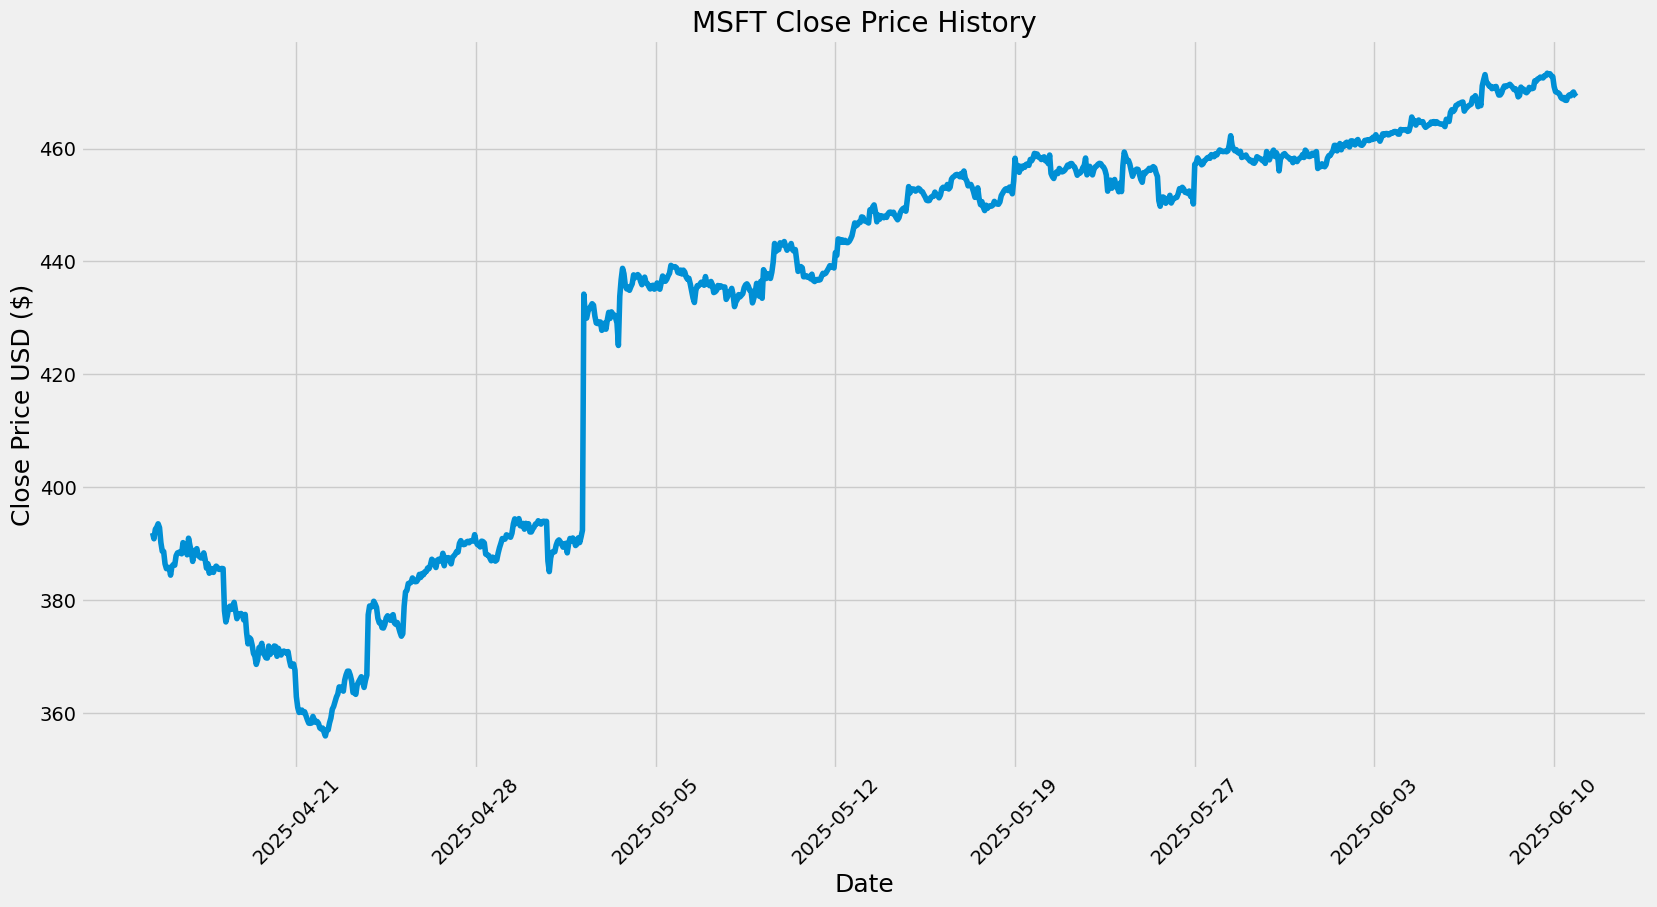

In [5]:
# Select the stock to train the model
stock = 'MSFT'
df = trends[stock]

# Plot the stock price graph
plt.figure(figsize=(18,9))
plt.title(stock + ' Close Price History')
plt.plot(range(df.index.size), df['Close'])
ticks = df.index.indexer_at_time('09:30')[::-5]    # step in days
plt.xticks(ticks ,df.index.date[ticks] ,rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

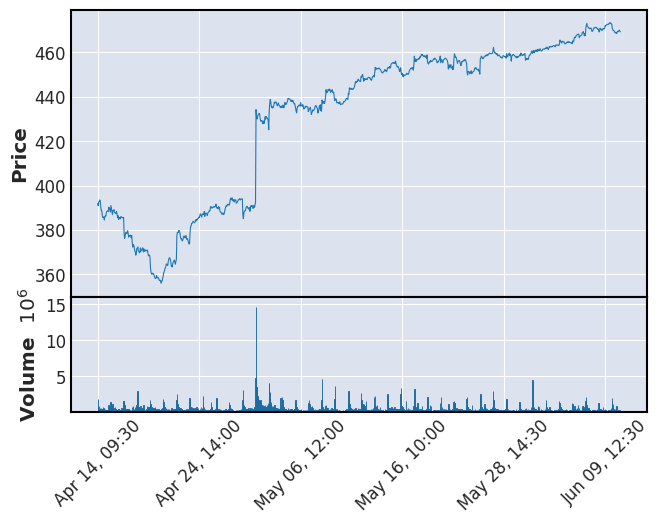

In [6]:
# Used to compare chart
mpf.plot(df, type='line', volume=True)

In [9]:
# @title Not used
'''
# Create figure and matplotlib plots with some additional formatting
fig, (top, bot) = plt.subplots(2, 1, sharex=True, figsize=(10,5),
                               gridspec_kw=dict(height_ratios=[0.75,0.25]))
top.plot(range(df.index.size), df['Close'])
top.set_title(stock+' Closed Price History', pad=20, size=14, weight='semibold')
top.set_ylabel('Price', labelpad=10)
top.grid(axis='x', alpha=0.3)
bot.bar(range(df.index.size), df['Volume'], width=1)
bot.set_ylabel('Volume', labelpad=10)

# Set fixed major and minor tick locations
ticks_date = df.index.indexer_at_time('09:30')[::-5]    # step in days
bot.set_xticks(ticks_date)

# Format major and minor tick labels
labels_date = [maj_tick.strftime('\n%d-%b').replace('\n0', '\n')
               for maj_tick in df.index[ticks_date]]

bot.set_xticklabels(labels_date)
bot.figure.autofmt_xdate(rotation=0, ha='center', which='both')
'''
pass

# 2. Data Prepocess Module

In [7]:
# Used to normalize the data
from sklearn.preprocessing import MinMaxScaler

# Used to standardize the data (Not used)
# from sklearn.preprocessing import StandardScaler

# Used for data padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

2025-06-10 13:42:02.941957: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-10 13:42:02.958028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749588122.978857  998377 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749588122.985611  998377 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749588123.004938  998377 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [8]:
raw_data = df.filter(['Close'])

dataset = raw_data.copy().to_numpy()

train_data_n = int(len(dataset)*0.8)
test_data_n = len(dataset) - train_data_n

train_data_n, test_data_n, len(dataset)

(824, 207, 1031)

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# print(scaled_data)

In [10]:
# Training Set & Validation Set Preprocess
train_data = scaled_data[0:train_data_n, :]

x_train = []
y_train = []

# Choose the size of predictors
sequence_size = 60

for i in range(sequence_size, train_data_n):
  x_train.append(train_data[i-sequence_size:i, 0])
  y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(764, 60, 1)

## 2 Different Approaches on Constructing Testing Set

In [11]:
# Testing Set Preprocess (Stock Price Predictor)
# Used actual prices in all the predictors.
# Best for predicting stock price.
# Pros: High Accuracy
# Cons: Can predict 1 step ahead only. (In our case, 15 minutes ahead)

test_data1 = scaled_data[train_data_n - 60: , :]

x_test1 = []
y_test1 = dataset[train_data_n: , :]

for i in range(sequence_size, len(test_data1)):
  x_test1.append(test_data1[i-60:i, 0])

x_test1 = np.array(x_test1)

x_test1 = np.reshape(x_test1, (x_test1.shape[0], x_test1.shape[1], 1 ))
x_test1.shape

(207, 60, 1)

In [12]:
# Testing Set Preprocess (Stock Trend Predictor)
# Used combination of actual price and predicted price as predictors.
# Best for predicting stock trends.
# Pros: Can predict few steps ahead.
# Cons: Accuracy getting worse after a few predictions.
test_data2 = scaled_data[train_data_n - 60: train_data_n, :]

x_test2 = []
y_test2 = dataset[train_data_n: , :]

for i in range(0, sequence_size):
  partial_sequence = test_data2[i:sequence_size, 0]
  x_test2.append(partial_sequence)

for i in range(sequence_size, test_data_n):
  x_test2.append([0])

x_test2 = np.array(pad_sequences(x_test2, maxlen=sequence_size, padding='post', dtype='float32'))

x_test2 = np.reshape(x_test2, (x_test2.shape[0], x_test2.shape[1], 1 ))
x_test2.shape, y_test2.shape

((207, 60, 1), (207, 1))

#3. Data Training Module

In [13]:
# From Nvidia lab 6
from keras.preprocessing.sequence import pad_sequences
# from keras import utils

# Embedding and dropout used in nvidia.
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [14]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=False))    # Multi-layer LSTM
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.summary()

I0000 00:00:1749588154.558683  998377 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/limli/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,593 (463.25 KB)

 Trainable params: 118,593 (463.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=15)

Epoch 1/15


I0000 00:00:1749588165.028101 1072239 cuda_dnn.cc:529] Loaded cuDNN version 90300


764/764 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.0242
Epoch 2/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0026
Epoch 3/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0021
Epoch 4/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0018
Epoch 5/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0016
Epoch 6/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0020
Epoch 7/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0015
Epoch 8/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0015
Epoch 9/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0014
Epoch 10/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0012
Epoch 11/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0015
Epoch 12/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0011
Epoch 13/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.0015
Epoch 14/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0013
Epoch 15/15
764/764 ━━━━━━━━━━━━━━━━━━━━

# 4. Prediction Module

## Stock Price Predictor

In [16]:
predictions = model.predict(x_test1)
#print(predictions.size)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test1) ** 2)))
rmse

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


np.float64(1.289476252892179)

                                Close  Predictions
Datetime                                          
2025-05-29 14:00:00-04:00  458.170013   460.096741
2025-05-29 14:15:00-04:00  457.510010   460.069336
2025-05-29 14:30:00-04:00  458.294098   459.704773
2025-05-29 14:45:00-04:00  457.859985   460.006439
2025-05-29 15:00:00-04:00  457.690002   459.876678
...                               ...          ...
2025-06-10 12:30:00-04:00  469.339996   470.015930
2025-06-10 12:45:00-04:00  469.777008   470.005219
2025-06-10 13:00:00-04:00  470.019989   470.230133
2025-06-10 13:15:00-04:00  469.498413   470.439514
2025-06-10 13:30:00-04:00  469.230011   470.242706

[207 rows x 2 columns]


/tmp/ipykernel_998377/219293824.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


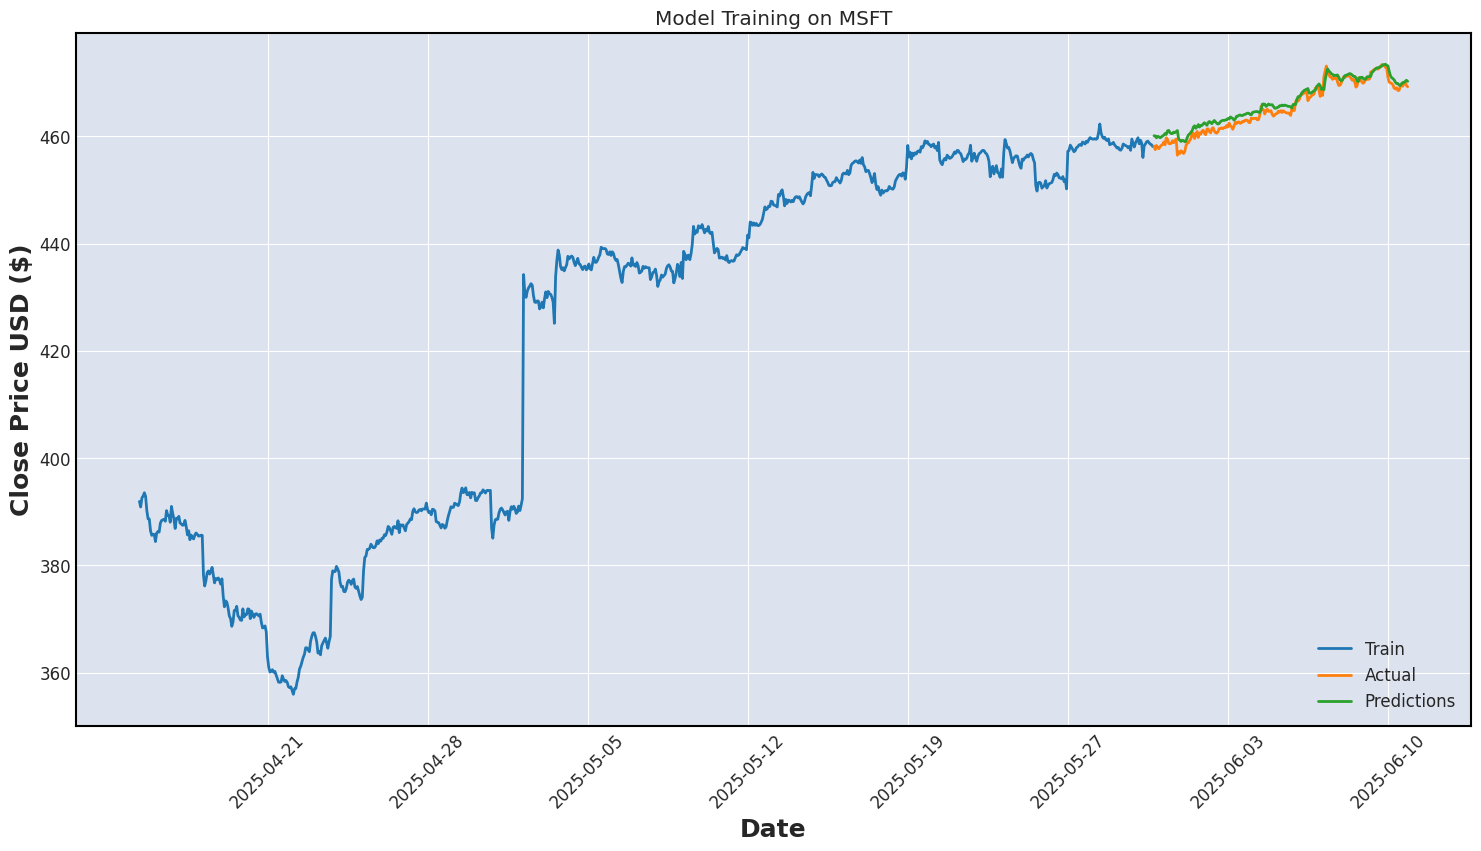

In [17]:
train = raw_data[:train_data_n]
valid = raw_data[train_data_n:]
valid['Predictions'] = predictions

print(valid)

# Visualize the data
plt.figure(figsize=(18,9))
plt.title('Model Training on ' + stock)

plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(range(train.index.size), train['Close'])
plt.plot(range(train.index.size, train.index.size + valid.index.size), valid[['Close', 'Predictions']])
ticks = df.index.indexer_at_time('09:30')[::-5]    # step in days
plt.xticks(ticks ,df.index.date[ticks] ,rotation=45)
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

## Stock Trend Predictor

In [18]:
predictions_list = []

for i in range(0, test_data_n):
  single_test = np.reshape(x_test2[i], (1, x_test2.shape[1], 1))

  prediction = model.predict(single_test)

  predictions_list.append(prediction[0])

  if (test_data_n - i <= sequence_size and test_data_n - i > 0):
    for j, k in zip(range(i+1, test_data_n), range(sequence_size-1, sequence_size-test_data_n+i, -1)): #sequence_size
      x_test2[j, k] = prediction
  else:
    for j in range(i+1, i+sequence_size+1):
      x_test2[j, -j+i] = prediction


np_predictions = np.array(predictions_list)

predictions = scaler.inverse_transform(np_predictions)

rmse = np.sqrt(np.mean(((predictions - y_test2) ** 2)))
rmse

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

np.float64(9.814450473833405)

                                Close  Predictions
Datetime                                          
2025-05-29 14:00:00-04:00  458.170013   460.105408
2025-05-29 14:15:00-04:00  457.510010   461.157806
2025-05-29 14:30:00-04:00  458.294098   462.121735
2025-05-29 14:45:00-04:00  457.859985   462.975677
2025-05-29 15:00:00-04:00  457.690002   463.736511
...                               ...          ...
2025-06-10 12:30:00-04:00  469.339996   475.823425
2025-06-10 12:45:00-04:00  469.777008   475.823425
2025-06-10 13:00:00-04:00  470.019989   475.823425
2025-06-10 13:15:00-04:00  469.498413   475.823425
2025-06-10 13:30:00-04:00  469.230011   475.823425

[207 rows x 2 columns]


/tmp/ipykernel_998377/219293824.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


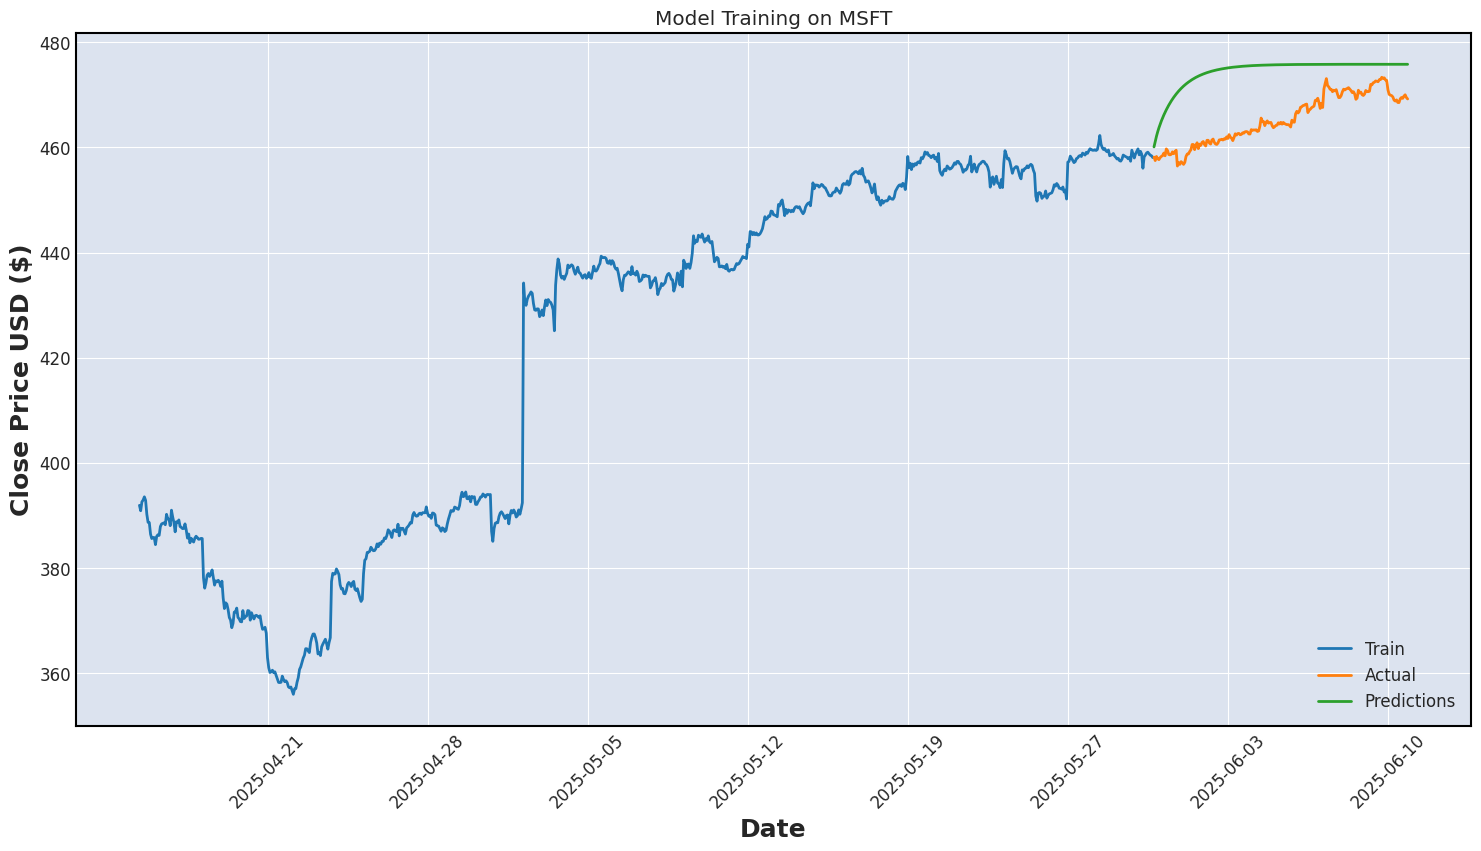

In [19]:
train = raw_data[:train_data_n]
valid = raw_data[train_data_n:]
valid['Predictions'] = predictions

print(valid)

# Visualize the data
plt.figure(figsize=(18,9))
plt.title('Model Training on ' + stock)

plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(range(train.index.size), train['Close'])
plt.plot(range(train.index.size, train.index.size + valid.index.size), valid[['Close', 'Predictions']])
ticks = df.index.indexer_at_time('09:30')[::-5]    # step in days
plt.xticks(ticks ,df.index.date[ticks] ,rotation=45)
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.798144751792852


/tmp/ipykernel_998377/773994002.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


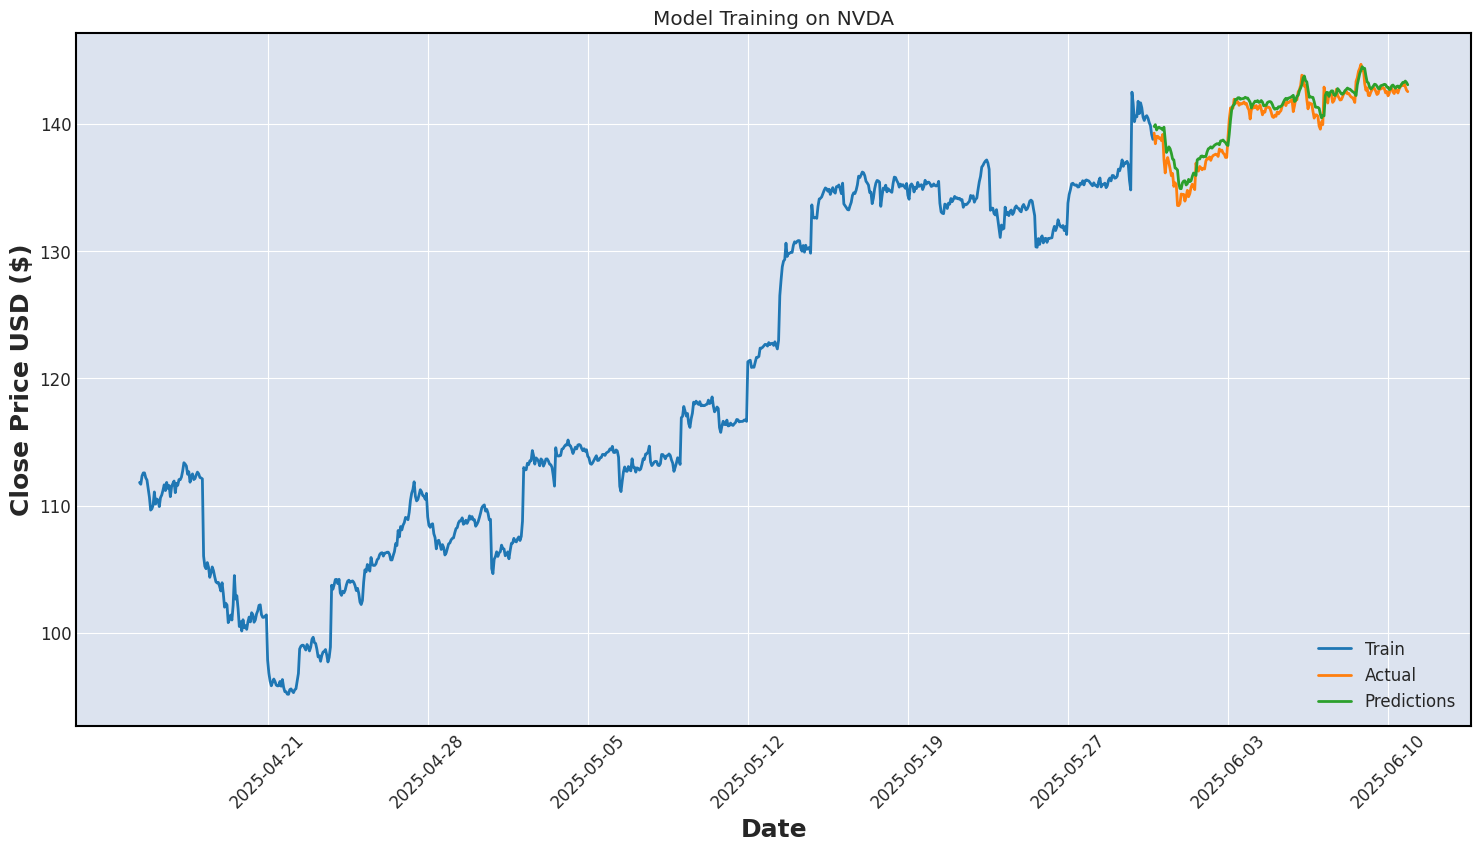

In [21]:
# @title Cross reference with other stock market
stock = 'NVDA'
df = trends[stock]

raw_data = df.filter(['Close'])
dataset = raw_data.values
train_data_n = int(len(dataset)*0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)



# Testing Set Preprocess
test_data = scaled_data[train_data_n - 60: , :]

x_test = []
y_test = dataset[train_data_n: , :]

for i in range(sequence_size, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))




# Prediction
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)




train = raw_data[:train_data_n]
valid = raw_data[train_data_n:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(18,9))
plt.title('Model Training on ' + stock)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(range(train.index.size), train['Close'])
plt.plot(range(train.index.size, train.index.size + valid.index.size), valid[['Close', 'Predictions']])
ticks = df.index.indexer_at_time('09:30')[::-5]    # step in days
plt.xticks(ticks ,df.index.date[ticks] ,rotation=45)
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()